# An Introduction to Image Classification with scikit-learn

By [Ellie Birbeck](https://elliebirbeck.com) for [Hyperion Dev](https://blog.hyperiondev.com/)


### Introduction

This tutorial is an introduction to machine learning with [scikit-learn](http://scikit-learn.org/), a popular and well-documented Python framework. We’ll be using [Python 3](https://www.python.org/downloads/) to build an image recognition classifier which accurately determines the house number displayed in images from Google Street View. You’ll need some programming skills to follow along, but we’ll be starting from the basics in terms of machine learning - no previous experience necessary.

So what is machine learning? It’s an area of artificial intelligence where algorithms are used to learn from data and improve their performance at given tasks. For example, if we previously had wanted to build a program which could distinguish between an image of the number 1 and an image of the number 2, we might have set up lots and lots of rules looking for straight lines vs curly lines, or a horizontal base vs a diagonal tip etc. What machine learning allows us to do instead, is feed an algorithm with many examples of images which have been labelled with the correct number. The algorithm then learns for itself which features of the image are distinguishing, and can make a prediction when faced with a new image it hasn’t seen before. 

Typically for a machine learning algorithm to perform well, we need lots of examples in our dataset, and the task needs to be one which is solvable through finding predictive patterns. There are different types of tasks categorised in machine learning, one of which is a classification task. This simply means that we are aiming to predict one of several discrete classes (labels). An example of this could be predicting either yes or no, or predicting either red, green, or yellow. This is in contrast to regression, a different type of task which makes predictions on a continuous numerical scale - for example predicting the number of fraudulent credit card transactions. 

### Dataset

For this tutorial we’ll be using a dataset from [Stanford University](http://ufldl.stanford.edu/housenumbers). It contains images of house numbers taken from Google Street View. Each one has been cropped to 32x32 pixels in size, focussing on just the number. Some examples are shown below. 

![house-numbers](http://ufldl.stanford.edu/housenumbers/32x32eg.png)

We need to download the dataset and save it in the same directory as this notebook. There are three different datasets available of different sizes. In this tutorial we will be using the largest at 1.3GB in size, available to download [here](http://ufldl.stanford.edu/housenumbers/extra_32x32.mat). If you want to save on space or time, download [this one](http://ufldl.stanford.edu/housenumbers/train_32x32.mat) at only 182MB, but expect worse results due to the reduced amount of data.

There are a total of 531131 images in our dataset, and we will load them in as one 4D-matrix of shape `32 x 32 x 3 x 531131`. This represents each 32x32 image in RGB format (so the 3 red, green, blue colour channels) for each of our 531131 images. We’ll be predicting the number shown in the image, from one of ten classes (0-9). Note that in this dataset the number 0 is represented by the label 10. The labels are stored in a 1D-matrix of shape `531131 x 1`. You can check the dimensions of a matrix `X` at any time in your program using `X.shape`.  

Although this tutorial focuses on just house numbers, the process we will be using can be applied to any kind of classification problem. Autonomous vehicles are a huge area of application for research in computer vision at the moment, and the self-driving cars being built will need to be able to interpret their camera feeds to determine traffic light colours, road signs, lane markings, and much more. With this in mind, at the end of the tutorial you can think about how to expand upon what you’ve developed here.


### Feature Processing

Now let’s begin! To understand the data we’re using, we can start by loading and viewing the image files. First we need to import three libraries.

In [23]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Then we can load the training dataset into a temporary variable `train_data`, which is a dictionary object. The dictionary contains two variables `X` and `y`. `X` is our 4D-matrix of images, and `y` a 1D-matrix of the corresponding labels. So to access the i-th image in our dataset we would be looking for `X[:,:,:,i]`, and its label would be `y[i]`. Let’s do this for image 10.

In [24]:
# load our dataset
train_data = scipy.io.loadmat('extra_32x32.mat')

In [25]:
# extract the images and labels from the dictionary object
X = train_data['X']
y = train_data['y']

[2]


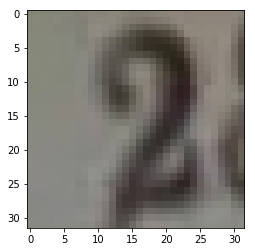

In [26]:
# view an image (e.g. 10) and print its corresponding label
img_index = 10
plt.imshow(X[:,:,:,img_index])
print(y[img_index])

> The first code block will take a short while to load if you are using the largest dataset. If you are getting errors here, check two things. Firstly, ensure that your downloaded dataset is saved in the same directory as this notebook. And secondly, ensure the filename matches the code (if you downloaded the smaller dataset, you will have a different filename of `'train_32x32.mat'`).

As you can see, we load up an image showing house number 2, and the console output from our printed label is also 2. You can change the index of the image (to any number between 0 and 531130) and check out different images and their labels if you like. 

Now, to use these images with a machine learning algorithm, we first need to vectorise them. This essentially involves stacking up the 3 dimensions of each image (the width x height x colour channels) to transform it into a 1D-matrix. This gives us our feature vector, although it’s worth noting that this is not really a feature vector in the usual sense. Features usually refer to some kind of quantification of a specific trait of the image, not just the raw pixels. Raw pixels can be used successfully in machine learning algorithms, but this is typically with more complex models such as convolutional neural networks, which can learn specific features themselves within their network of layers. 

In [27]:
from sklearn.utils import shuffle

X = X.reshape(X.shape[0]*X.shape[1]*X.shape[2],X.shape[3]).T
y = y.reshape(y.shape[0],)
X, y = shuffle(X, y, random_state=42)

We’re also shuffling our data just to be sure there are no underlying distributions. The library we’ve used for this ensures that the index pairings between our images in `X` and their labels in `y` are maintained through the shuffling process. You can use the parameter `random_state=42` if you want to replicate the results of this tutorial exactly.

### Machine Learning Algorithms

Now that we have our feature vector `X` ready to go, we need to decide which machine learning algorithm to use. We don’t need to explicitly program an algorithm ourselves - luckily frameworks like scikit-learn do this for us. Scikit-learn offers a range of algorithms, with each one having different advantages and disadvantages. We won’t be going into the details of each, but it’s useful to think about the distinguishing elements of our image recognition task and how they relate to the choice of algorithm. This could include the amount of data we have, the type of problem we’re solving, the format of our output label etc.

If you don’t have any prior experience in machine learning, you can use this helpful [cheat sheet](http://scikit-learn.org/stable/tutorial/machine_learning_map/) to guide you in which algorithms to try out depending on your data. But I would really recommend reading up and understanding how the algorithms work for yourself, if you plan to delve deeper into machine learning. This will be especially useful for tuning hyperparameters. Hyperparameters are input values for the algorithm which can tune its performance, for example adjusting the maximum depth of a decision tree. 

For now we will be using a Random Forest approach with default hyperparameters. You can learn more about Random Forests [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html ), but in brief they are a construction of multiple decision trees with an output that averages the results of individual trees to prevent fitting too closely to any one tree. 

First we import the necessary library and then define our classifier.

In [28]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

print(clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


We can also print the classifier to the console to see the parameter settings used. Although we haven’t changed any from their default settings, it’s interesting to take a look at the options and you can experiment with tuning them at the end of the tutorial. 

### Training the model

We’re now ready to train and test our data. But before we do that, we need to split our total collection of images into two sets - one for training and one for testing. You can also add a third set for development/validation, which you can read more about [here](https://en.wikipedia.org/wiki/Training,_test,_and_validation_sets).

Keeping the testing set completely separate from the training set is important, because we need to be sure that the model will perform well in the real world. Once trained, it will have seen many example images of house numbers. We want to be sure that when presented with new images of numbers it hasn’t seen before, that it has actually learnt something from the training and can generalise that knowledge - not just remember the exact images it has already seen.

Usually we use between 70-90% of the data for training, though this varies depending on the amount of data collected, and the type of model trained. For example, neural networks are often used with extremely large amounts of data and may sample 99% of the data for training. In this tutorial we’ll go with 80%.  

Again, using the largest dataset means that fitting the model may take a little while.

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Test Results

Now we’re ready to use our trained model to make predictions on new data.

In [30]:
from sklearn.metrics import accuracy_score

preds = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test,preds))

Accuracy: 0.76013631186


Your accuracy result should be ~76% if you opted to use the original large dataset, and will be less if you used a smaller one.

So our model has learnt how to classify house numbers from Google Street View with a relatively high accuracy simply by showing it a few hundred thousand examples. Given a baseline measure of 10% accuracy for random guessing, we’ve made significant progress. There’s still a *lot* of room for improvement here, but it’s a good result from a simple untuned learning algorithm on a real-world problem. You can even try going outside and creating a 32x32 image of your own house number to test on. 

### Extensions

What can you do next? How can you expand upon this tutorial?

If you’re interested in experimenting further within the scope of this tutorial, try training the model only on images of house numbers 0-8. Then test it on images of number 9. Do you think we can transfer the knowledge learnt to a new number? Why or why not? 
You could also perform some error analysis on the classifier and find out which images it’s getting wrong. Try to spot patterns in the errors, figure out why it’s making mistakes, and think about what you can do to mitigate this. 
Take a look into the distribution of different digits in the dataset, and you’ll realise it’s not even. Is this having an effect on our results? 

If you want to go further into the realms of image recognition, you could start by creating a classifier for more complex images of house numbers. This [dataset](http://ufldl.stanford.edu/housenumbers/extra.tar.gz) contains uncropped images, which show the house number from afar, often with multiple digits. Next you could try to find more varied data sets to work with - perhaps identify traffic lights and determine their colour, or recognise different street signs. Finding or creating labelled datasets is the tricky part, but we’re not limited to just Street View images! There are a ton of resources available online so go ahead and see what you can build next.

A Github repo with the complete source code file for this project is available [here](https://github.com/elliebirbeck/sklearn-tutorial).
